## CUNEF

### Master Universitario en Ciencia de Datos

**Dep:**
Aprendizaje Automatico

**Practica 3**\
Yelp Analysis

### Case of Study:
Create a Machine Learning Algorithm to identify possible business insigts based on different information  related to business reviews extracted from an open datasource of Yelp page.

### Import the libraries that we are going to use

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors


from mpl_toolkits.mplot3d import Axes3D

# 1. LOADING THE DATASETS

In [2]:
df_user=pd.read_parquet('../00_data/01_process/user_info_data.parquet')
df_user.head(10)

,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,num_friends,times_elite
0,585,2007,7217,1259,5994,267,3.91,250,65,55,56,18,232,844,467,467,239,180,14995,1
1,4333,2009,43091,13066,27281,3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946,4646,14
2,665,2008,2086,1010,1003,52,3.32,89,13,10,17,3,66,96,119,119,35,18,381,5
3,224,2005,512,330,299,28,4.27,24,4,1,6,2,12,16,26,26,10,9,131,3
4,79,2007,29,15,7,1,3.54,1,1,0,0,0,1,1,0,0,0,0,27,0
5,1221,2005,14953,9940,11211,1357,3.85,1713,163,191,361,147,1212,5696,2543,2543,815,323,5843,9
6,12,2009,6,1,0,1,2.75,0,0,0,0,0,0,1,0,0,0,0,23,0
7,358,2008,399,102,143,23,3.73,4,7,2,0,0,8,6,12,12,5,0,82,0
8,40,2008,109,40,46,7,4.04,2,0,0,3,0,3,4,5,5,3,1,488,0
9,109,2010,154,20,23,4,3.40,0,0,0,0,0,1,6,3,3,0,0,64,0


# 2. Pre Processing (Previous steps to modeling)

In [3]:
# We are gointo to save the column names for future use
label_columns=df_user.columns

* First thing we are going to do is to scale the data because the cluster algoritms works better when data is scaled

In [4]:
# Create the scale model
scaler=StandardScaler()
df_user_scale=scaler.fit_transform(df_user[df_user.columns])

* The clusterings work better when there are less features to examinate, so we are going to execute a PCA to reduce the number of features or components. To do this, first we are going to identify how many components represents the majority of our data features.

In [5]:
pca = PCA()
pca.fit(df_user_scale)
exp_var_pca = pca.explained_variance_ratio_ #return the variance that explains each feature
cum_sum_eigenvalues = np.cumsum(exp_var_pca) #return the cumulative sum of the elements along a given axis.

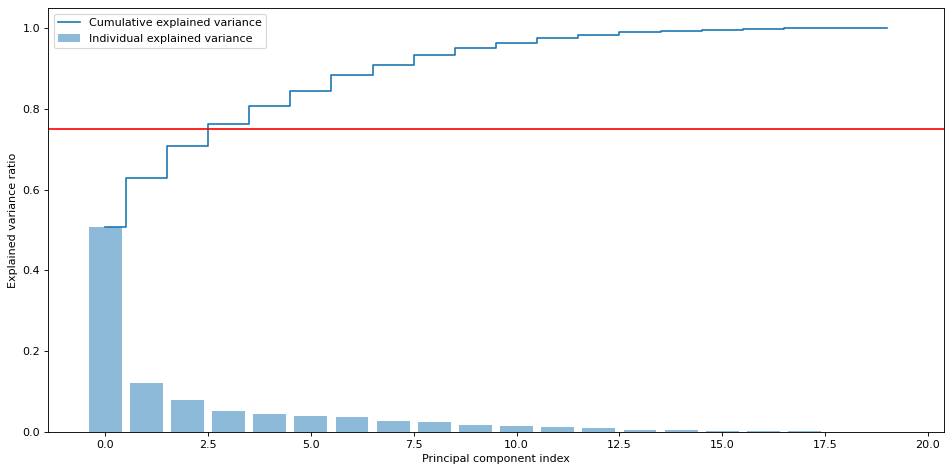

In [6]:
# We are going to graphic the eigenvalues to identify the number of components that best describe the dataframe

threshold = 0.75
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

- Based on the cumulative PCA analysis, if we want to take into consideration the **75% of explainability from the data we should have 3 components** or variables into consideration when doing the PCA.

#### Execute the PCA with 3 components

In [7]:
pca = PCA(n_components=3)
df_user_3 = pca.fit_transform(df_user_scale)

In [8]:
df_user_3=pd.DataFrame(df_user_3)
df_user_3.columns=(['PC1','PC2','PC3'])

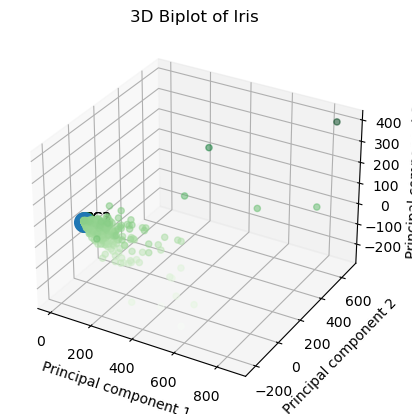

In [9]:
# Define scaled features as arrays
xdata = df_user_3['PC1']
ydata = df_user_3['PC2']
zdata = df_user_3['PC3']
 
# Initialize the 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
# Plot 3D scatterplot of PCA
ax.scatter3D(
    xdata, 
    ydata, 
    zdata, 
    c=zdata, 
    cmap='Greens', 
    alpha=0.5)
 
# Define the x, y, z variables
loadings = pca.components_
xs = loadings[0]
ys = loadings[1]
zs = loadings[2]
 
# Plot the loadings
for i, varnames in enumerate(df_user_3.columns):
    ax.scatter(xs[i], ys[i], zs[i], s=200)
    ax.text(
        xs[i] + 0.1, 
        ys[i] + 0.1, 
        zs[i] + 0.1, 
        varnames)
 
# Plot the arrows
x_arr = np.zeros(len(loadings[0]))
y_arr = z_arr = x_arr
ax.quiver(x_arr, y_arr, z_arr, xs, ys, zs)
 
# # Plot title of graph
plt.title(f'3D Biplot of Iris')
 
# # Plot x, y, z labels
ax.set_xlabel('Principal component 1', rotation=150)
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3', rotation=60)
 
plt.show()

We can see that there is an outlier in the original dataset. As the K-mean is ssensitive to outliers we are going to remove the outlier and execute.

### Conclusion

* As we can see in the 3D graph, there is an outlier in our data. Because the K-mean is not good with outliers it is better to execute a DBSCAN that relies on difference in density and it is not suceptible to outliers. However we are going to do both and see the difference between both

# Understanding the each component in the PCA

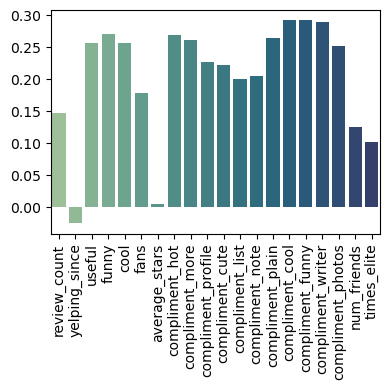

In [24]:
loadings=pca.components_
pca_explain_0=pd.DataFrame(loadings[0]).transpose()
pca_explain_0.columns=df_user.columns

plt.subplots(figsize=(4, 4))
sns.barplot(data=pca_explain_0, palette="crest")
plt.xticks(rotation=90)
plt.tight_layout()

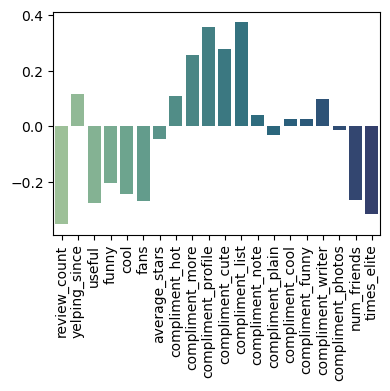

In [26]:
pca_explain_1=pd.DataFrame(loadings[1]).transpose()
pca_explain_1.columns=df_user.columns

plt.subplots(figsize=(4, 4))
sns.barplot(data=pca_explain_1, palette="crest")
plt.xticks(rotation=90)
plt.tight_layout()

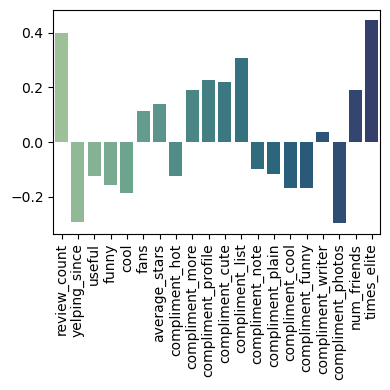

In [25]:
pca_explain_2=pd.DataFrame(loadings[2]).transpose()
pca_explain_2.columns=df_user.columns

plt.subplots(figsize=(4, 4))
sns.barplot(data=pca_explain_2, palette="crest")
plt.xticks(rotation=90)
plt.tight_layout()

If we want to understand the PCA components we can see the eigenvalues and how much impact each feature have on them:

* **PCA0** - The main features that have an impact in this component are the compliments of the their friends, primarly th cool, funny, writer amd photos compliments assign to the users.
* **PAC1** - For this component, the features that have an important role are the useful, funny and cool classification of the reviews.
* **PCA2** - For this component, what has more relevance is the amount of reviews that the user gives and the number of times that particular user was elite.

# 3. K means clustering

#### 3.1 Identify the num of clusters and execute the model

The first thing to do is to determinate the number of cluster that we want to separate the bataset of yelp users

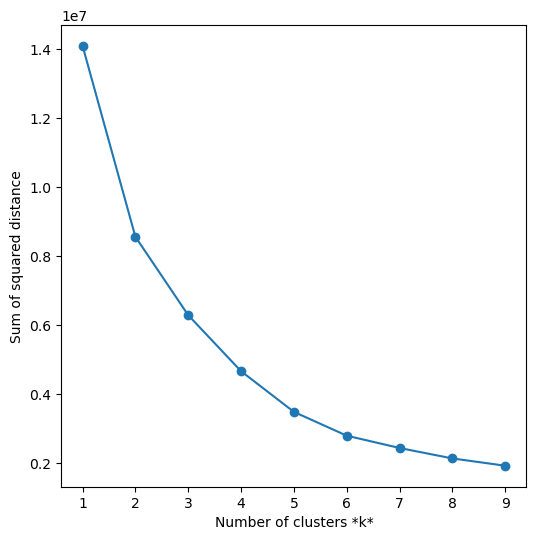

In [10]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_user_3)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

- At 4 clusters we can see that the slope starts to decrease so base on this and the changes of values are not that high, therefore **we are going to take into consideration 4 clusters for the K-mean analysis**. This will divide the different types of users in 4 big group to represent the different types of users that use the yelp platform.

In [12]:
# Execute the kmeans for our scaled and reduce dataset
k_clf = KMeans(n_clusters = 4, random_state = 33)
k_clf.fit(df_user_3)
pd_final_cluster = pd.DataFrame(k_clf.predict(df_user_3)) # In here we are predicting the types of clients and pass as Df
pd_final_cluster.columns = ['cluster'] 

# Combine the classifications of the clients to the original dataset in order to understan each customer behaviur
df_user_class = pd.concat([pd_final_cluster, df_user],axis=1)

# 4. DBSCAN Clustering

As we can see from the k-mean analysis, the 99% of the classification  was in just 1 category. We are going to execute a DBSCAN cluster method to remove any issue that can contain outliers or points that are segregated from the avergae points.

## 4.1 Base Model

In [16]:
df_user_3=pd.DataFrame(df_user_3).iloc[0:50000]
df_user_3.shape

(50000, 3)

In [17]:
clusterer = DBSCAN() # los parámetros del algoritmo por defecto son:

data = clusterer.fit_predict(df_user_3)
data=pd.DataFrame(data,columns=['clusters'])
data['clusters'].value_counts()

 0     48584
-1      1307
 1        21
 4        13
 3         9
 5         8
 9         7
 8         7
 7         7
 12        5
 14        5
 2         5
 10        5
 13        5
 6         4
 11        4
 15        4
Name: clusters, dtype: int64

**Insights:**

With the DBSCAN without adjustment we can see that there are 15 different classifications of the differents types of user. We said 15 because what is identify as group class -1 is in fact what the DBSCAN identified as noise.

We are going to adjust the hyperparameters of the DBSCAN model to see how the different classifications of users chaged.

## 4.2 Hyperparameters Adjustment

The hyperparameters that need to be tuned in the DBSCAN are epsilon (which is the maximun distance between the points) and the minimun sample (that is the minimun number of points to be consider a core point or a cluster).

We are going to use the technique of the KNN to determinate epsilon.

In [18]:
# Decrease the size of the dataset to be able to work with it
df_user_scale=pd.DataFrame(df_user_scale)
df_user_scale=df_user_scale.iloc[0:50000]
df_user_scale.columns=label_columns
df_user_scale.shape

(50000, 20)

#### Identifying the best minimun sample

- We are going to take as the **minumun sample number 20** as this is the number of features that we have in our dataset.

#### Identifying the best epsilon

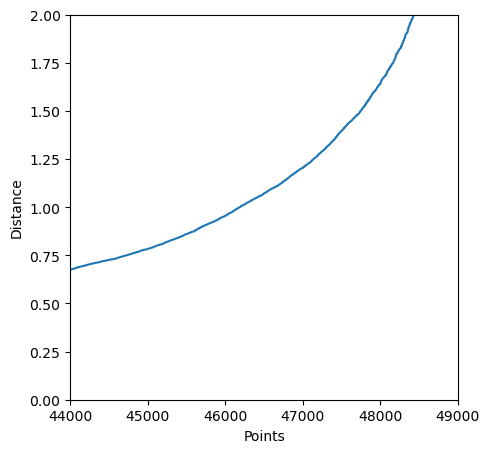

In [19]:
# We zoom the specific area where the elbow starts to form to identify the optimal number of epsilon
nearest_neighbors = NearestNeighbors(n_neighbors=20)
neighbors = nearest_neighbors.fit(df_user_scale)
distances, indices = neighbors.kneighbors(df_user_scale)
distances
distances = np.sort(distances[:,1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.gca().set_xlim(44000, 49000)
plt.gca().set_ylim(0, 2)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

* Based on the elbow curve executed, we are going to take an **epsilon of 1** as the distances of the different points

In [20]:
# Crete the new DBSCAN with the correct hyperparameters
clusterer = DBSCAN(eps=1, min_samples=20) # los parámetros del algoritmo por defecto son:

# Train the data and identify the new clusters of users
data = clusterer.fit_predict(df_user_scale)
data=pd.DataFrame(data,columns=['clusters'])
data['clusters'].value_counts()

 0    44716
-1     5102
 1      182
Name: clusters, dtype: int64

### Conclusion:

We can see that with the DBSCAN there are only 2 different categories of users. This is because of the amount of noise in the dataset and the separation of the clusters that this results show as conclusion. The negative class represents noise on the data.

# 5. Evaluation of each user classification

In [21]:
df_final=df_user[0:50000]
df_final=pd.concat([df_final, data],axis=1)

#### Evaluation of class 0 type of users

In [22]:
df_final[df_final['clusters']==0].describe()

,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,num_friends,times_elite,clusters
count,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,...,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.000000,44716.0
mean,44.073307,2012.007223,52.202321,14.206727,17.860810,1.895451,3.848508,0.809688,0.385634,0.106181,...,0.020731,1.277865,1.571317,1.468557,1.468557,0.882413,0.337351,89.667971,0.331112,0.0
std,57.080594,2.468963,80.420490,28.535983,32.840054,3.303982,0.709056,2.535749,0.930843,0.411287,...,0.188912,2.777630,3.709125,3.764833,3.764833,2.311810,1.232223,127.620606,1.044996,0.0
min,1.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
25%,9.000000,2010.000000,6.000000,1.000000,1.000000,0.000000,3.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.0
50%,22.000000,2012.000000,20.000000,4.000000,5.000000,1.000000,3.920000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,0.000000,0.0
75%,55.000000,2014.000000,61.000000,14.000000,18.000000,2.000000,4.310000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,118.000000,0.000000,0.0
max,543.000000,2019.000000,907.000000,475.000000,391.000000,34.000000,5.000000,56.000000,11.000000,7.000000,...,5.000000,49.000000,82.000000,66.000000,66.000000,38.000000,41.000000,1224.000000,6.000000,0.0


#### Evaluation of class 1 type of users

In [23]:
df_final[df_final['clusters']==1].describe()

,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,num_friends,times_elite,clusters
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.0
mean,251.038462,2011.714286,298.401099,69.472527,121.582418,11.467033,3.928791,4.423077,1.598901,0.703297,...,0.032967,8.686813,10.395604,10.598901,10.598901,6.296703,2.648352,78.329670,7.291209,1.0
std,64.250491,1.528989,105.536507,40.175813,55.846488,5.706109,0.309279,4.825361,1.638150,1.102428,...,0.207620,7.218434,6.689448,8.159230,8.159230,5.217892,3.018813,50.226461,0.455573,0.0
min,124.000000,2008.000000,114.000000,15.000000,29.000000,0.000000,3.050000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,7.000000,1.0
25%,203.250000,2011.000000,221.000000,42.000000,83.000000,7.000000,3.720000,1.000000,0.000000,0.000000,...,0.000000,4.000000,6.000000,4.000000,4.000000,2.000000,1.000000,38.250000,7.000000,1.0
50%,247.500000,2012.000000,291.000000,59.000000,112.000000,11.000000,3.920000,3.000000,1.000000,0.000000,...,0.000000,6.000000,9.000000,8.000000,8.000000,5.000000,2.000000,71.000000,7.000000,1.0
75%,300.750000,2013.000000,354.750000,90.000000,149.000000,15.000000,4.125000,6.000000,2.000000,1.000000,...,0.000000,12.000000,13.000000,16.000000,16.000000,9.000000,4.000000,107.750000,8.000000,1.0
max,404.000000,2015.000000,645.000000,222.000000,357.000000,29.000000,4.690000,21.000000,8.000000,6.000000,...,2.000000,36.000000,39.000000,34.000000,34.000000,27.000000,16.000000,214.000000,8.000000,1.0


### Cluster Conclusion:

We can see that the users of the cluster class 0 have the follow characteristics:

    1.The number of reviews that group 0 creates are low comparing it to group 1, with a mean of total reviews written for group 0 of 44 reviews and a mean of reviews written by group 1 of 251. 
    2. The average amount of fans that group 0 users assign is reduce, with an average of approximatelly 1 fan in comparison with group 1 which we can see have more fans with an average of approximatelly 11.
    3. They tend to get not a lot of compiments for their reviews comparing it with group 1 which tends to have more compliments by their followers.
    4. The number of times that users from numb 1 cluster were elite is higher than the average amount of times that users from group 1 were elite.
    
We can infer that from both groups, group 1 is a important group as the number of reviews is high and also the number of times that this cluster was elite is higher. Therefore we can infer that this cluster of groups have a lot of ability to infer in other people in comparison with group 0.